In [8]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch
import numpy as np
from torchvision import models
from torch.nn import functional as F

__all__ = ['vgg19']
model_urls = {
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
}

class VGG_DL(nn.Module):
    def __init__(self, features, down=8, o_cn=1, final='abs'):
        super(VGG, self).__init__()
        self.down = down
        self.final = final
        self.reg_layer = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 1, kernel_size=4,stride=2,padding=1),
        )
        self._initialize_weights()
        self.features = features

    def forward(self, x):
        x = self.features(x)
        x = self.reg_layer(x)
        if self.final == 'abs':
            x = torch.abs(x)
        elif self.final == 'relu':
            x = torch.relu(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    # in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            # conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'A': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 512, 512, 512],
    'C': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512],    
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512],    
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512],
    'F': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512]
}


def vgg_dl(down=1, bn=False, o_cn=1, final='abs'):
    """VGG 19-layer model (configuration "E")
        model pre-trained on ImageNet
    """
    model = VGG(make_layers(cfg['A'], batch_norm=False,dilation=True), down=down, o_cn=o_cn, final=final)
    # model.load_state_dict(model_zoo.load_url(model_urls['vgg19']), strict=False)
    return model

In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F
# from misc.layer import Conv2d, FC
from torchvision import models
# from misc.utils import *


class VGG16_LCM(nn.Module):
    def __init__(self, load_weights=False):
        super(VGG16_LCM, self).__init__()

        self.layer5 = self.VGG_make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M',
                                            512, 512, 512, 'M', 512, 512, 512, 'M'])

        self.reg_layer = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, 1),
            nn.AvgPool2d(2, 2),
        )

        if load_weights:
            mod = models.vgg16(pretrained=False)
            pretrain_path = './models/Pretrain_Model/vgg16-397923af.pth'
            mod.load_state_dict(torch.load(pretrain_path))
            print("loaded pretrain model: " + pretrain_path)

            self._initialize_weights()
            self.layer5.load_state_dict(mod.features[0:31].state_dict())

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.layer5(x)
        x = self.reg_layer(x)

        return x

    def VGG_make_layers(self, cfg, in_channels=3, batch_norm=False, dilation=1):
        d_rate = dilation
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

In [7]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch
import numpy as np
from torchvision import models
from torch.nn import functional as F

__all__ = ['vgg19']
model_urls = {
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
}

class VGG(nn.Module):
    def __init__(self, features, down=8, o_cn=1, final='abs'):
        super(VGG, self).__init__()
        self.down = down
        self.final = final
        self.reg_layer = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, o_cn,kernel_size=4,stride=2,padding=1)
        )
        self._initialize_weights()
        self.features = features

    def forward(self, x):
        x = self.features(x)
        if self.down < 16:
            x = F.interpolate(x, scale_factor=2)
        x = self.reg_layer(x)
        if self.final == 'abs':
            x = torch.abs(x)
        elif self.final == 'relu':
            x = torch.relu(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    # in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            # conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'C': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512],    
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512],    
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512],
    'F': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512]
}


def vgg19(down=8, bn=False, o_cn=1, final='abs'):
    """VGG 19-layer model (configuration "E")
        model pre-trained on ImageNet
    """
    model = VGG(make_layers(cfg['E'], batch_norm=False), down=down, o_cn=o_cn, final=final)
    model.load_state_dict(model_zoo.load_url(model_urls['vgg19']), strict=False)
    return model

In [ ]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch
import numpy as np
from torchvision import models
from torch.nn import functional as F

__all__ = ['vgg19']
model_urls = {
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
}

class VGGDialated(nn.Module):
    def __init__(self, features, down=8, o_cn=1, final='abs'):
        super(VGG, self).__init__()
        self.down = down
        self.final = final
        self.reg_layer = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, o_cn,kernel_size=4,stride=2,padding=1)
        )
        self._initialize_weights()
        self.features = features

    def forward(self, x):
        x = self.features(x)
        if self.down < 16:
            x = F.interpolate(x, scale_factor=2)
        x = self.reg_layer(x)
        if self.final == 'abs':
            x = torch.abs(x)
        elif self.final == 'relu':
            x = torch.relu(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    # in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            # conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'C': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512],    
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512],    
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512],
    'F': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512]
}


def vgg19(down=8, bn=False, o_cn=1, final='abs'):
    """VGG 19-layer model (configuration "E")
        model pre-trained on ImageNet
    """
    model = VGG(make_layers(cfg['E'], batch_norm=False), down=down, o_cn=o_cn, final=final)
    model.load_state_dict(model_zoo.load_url(model_urls['vgg19']), strict=False)
    return model

In [ ]:
import torch.nn as nn
import torch
from torchvision import models
import torch.nn.functional as F
import os, sys


class CSRNet_LCM(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet_LCM, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = ['M', 512, 512, 'M', 512, 256, 'M', 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=2)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        if load_weights:
            mod = models.vgg16(pretrained=False)
            pretrain_path = '/root/vgg16-397923af.pth'
            mod.load_state_dict(torch.load(pretrain_path))
            print("loaded pretrain model: " + pretrain_path)

            self._initialize_weights()
            self.frontend.load_state_dict(mod.features[0:23].state_dict())

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, in_channels=3, batch_norm=False, dilation=1):
    d_rate = dilation
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [17]:
import torch.nn as nn
import torch
from torchvision import models
import torch.nn.functional as F
import os, sys

class MCNN(nn.Module):
    '''
    Implementation of Multi-column CNN for crowd counting
    '''
    def __init__(self,load_weights=False):
        super(MCNN,self).__init__()

        self.branch1=nn.Sequential(
            nn.Conv2d(3,16,9,padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,16,7,padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,8,7,padding=3),
            nn.ReLU(inplace=True)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3,20,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40,20,5,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20,10,5,padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48,24,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24,12,3,padding=1),
            nn.ReLU(inplace=True)
        )

        self.fuse=nn.Sequential(nn.Conv2d(30,1,1,padding=0))

        if not load_weights:
            self._initialize_weights()

    def forward(self,img_tensor):
        x1=self.branch1(img_tensor)
        x2=self.branch2(img_tensor)
        x3=self.branch3(img_tensor)
        x=torch.cat((x1,x2,x3),1)
        x=self.fuse(x)
        x = F.upsample(x,scale_factor=4,mode='bicubic')
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [ ]:
import torch.nn as nn
import torch
from torchvision import models
import torch.nn.functional as F
import os, sys

class MCNN_OcF(nn.Module):
    '''
    Implementation of Multi-column CNN for crowd counting
    '''
    def __init__(self,load_weights=False):
        super(MCNN_OcF,self).__init__()

        self.branch1=nn.Sequential(
            nn.Conv2d(3,16,9,padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,16,7,padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,8,7,padding=3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8,4,8,stride=2,padding=3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(4,8,8,stride=2,padding=3)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3,20,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40,20,5,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20,10,5,padding=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(10,5,6,stride=2,padding=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(5,10,6,stride=2,padding=2)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48,24,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24,12,3,padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(12,6,4,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(6,12,4,stride=2,padding=1)
        )

        self.fuse=nn.Sequential(nn.Conv2d(30,1,1,padding=0))


        if not load_weights:
            self._initialize_weights()

    def forward(self,img_tensor):
        x1=self.branch1(img_tensor)
        x2=self.branch2(img_tensor)
        x3=self.branch3(img_tensor)
        x=torch.cat((x1,x2,x3),1)
        x=self.fuse(x)
        # x = F.upsample(x,scale_factor=4,mode='bicubic')
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

def convert_DM_to_LCM(den_map, patch_size=64):
    ''' input density map(numpy)
        output local counting map(numpy) '''
    den_map = torch.from_numpy(den_map)
    den_map = den_map.unsqueeze(0)    # 2D to 4D
    den_map = den_map.unsqueeze(0)
    filter = torch.ones(1, 1, patch_size, patch_size, requires_grad=False)
    lc_map = F.conv2d(den_map, filter, stride=patch_size)
    lc_map = lc_map.squeeze()
    lc_map = lc_map.numpy()
    return lc_map


# Density Map Generator

In [ ]:
print((k>=1).sum())
keep = F.max_pool2d(k.unsqueeze(0),3,stride=1,padding=1).squeeze()

keep = (k==keep).float()*k
# keep = keep[keep>0.1]
k_max = keep.max()
keep[keep < k_max/2] = 0
keep[keep>0] = 1
# print(keep)
print((keep==1).sum())

weight = torch.ones(1,1,3,3).cuda()
pred_pos = F.conv2d(keep.unsqueeze(0),weight)
plt.figure()
plt.imshow(pred_pos.detach().cpu().squeeze())
# plt.imshow(keep.cpu())
# plt.figure()
# plt.imshow(maxpool.cpu())
# plt.figure()
# plt.imshow(avgpool.cpu())

# Dataset/Dataloader

### Transforms

In [3]:
DOWNSAMPLE = 4 #Input downsample factor after gaussian convolution(maxpool2d). 
LOG_PARA = 1 #Density map amplification factor

import random
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F


class RandomHorizontalFlip(object):
  """
  Randomly flip image and density map horizontally. Used for data augmentation.
  """

  def __init__(self):
    super(RandomHorizontalFlip,self).__init__()


  def __call__(self,img,den):
    """
    Randomly flip an image and its corresponding density map.

    Args:
      img (Image) : The image to be flipped
      den (Image) : The corresponding density map to be flipped

    Returns:
      (Image,Image): A tuple containing a randomly flipped image and density map
    """

    if(random.random()<0.5): #Flip randomly
      return img.transpose(Image.FLIP_LEFT_RIGHT), den.transpose(Image.FLIP_LEFT_RIGHT)

    return img,den

class ToLCM(object):
    def __init__(self,patch_size=64):
      super(ToLCM,self).__init__()
      self.patch_size = patch_size
    
    def __call__(self,tensor):
      patch_size = self.patch_size
      den_map = torch.Tensor(tensor)
      den_map = den_map.unsqueeze(0)
      filter = torch.ones(1, 1, patch_size, patch_size, requires_grad=False)
      lc_map = F.conv2d(den_map, filter, stride=patch_size)
      lc_map = lc_map.squeeze(0)
      return lc_map



class LabelNormalize(object):
    def __init__(self):
        super(LabelNormalize,self).__init__()

    def __call__(self, tensor):
        tensor = torch.from_numpy(np.array(tensor)).unsqueeze(0)
        tensor = tensor*LOG_PARA
        return tensor


### Dataset

In [4]:
from torch.utils import data
import os
from PIL import Image
import numpy as np
from pathlib import Path
import scipy
import scipy.io as io
import h5py




class SHHA(data.Dataset):
  """ShanghaiTechA dataset.

  Attributes:
    img_dir (string): Directory of the images.
    gt_dir (string): Directory of ground truths
    downsample (int): Factor of downsampling
    main_transform (callable): Transforms for both image and density map
    img_transform (callable): Transforms for image
    gt_transform (callable): Transforms for groundtruth
    img_files (list): List of the directory of all the images in the dataset
  """
  def __init__(self,img_dir,gt_dir,downsample=DOWNSAMPLE,main_transform=None,img_transform=None,gt_transform=None,lcm_transform=None):
    """
    Initializing dataset.

    Args:
      img_dir (string): Directory of the images.
      gt_dir (string): Directory of ground truths
      downsample (int): Factor of downsampling
      main_transform (callable, optional): Transforms for both image and density map
      img_transform (callable, optional): Transforms for image
      gt_transform (callable, optional): Transforms for groundtruth

    """
    super(SHHA,self).__init__()
    self.img_dir = img_dir
    self.gt_dir = gt_dir
    self.downsample = downsample
    self.main_transform = main_transform
    self.img_files = [filename for filename in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir,filename))]
    self.img_transform = img_transform
    self.gt_transform = gt_transform
    self.lcm_transform = lcm_transform

  def __len__(self):
    return len(self.img_files)

  def __getitem__(self,idx):
    img,den,gt_count,head_centers,fidt,distance = self.read_img_and_gt(idx) #gt_count,head_centers
    if self.main_transform is not None:
      img,den = self.main_transform(img,den)
    if self.img_transform is not None:
      img = self.img_transform(img)
    if self.gt_transform is not None:
      den = self.gt_transform(den)
      den = den * LOG_PARA
    if self.lcm_transform is not None:
      # pass
      den = self.lcm_transform(den)
    return img,den,gt_count,head_centers,fidt,distance,(img.shape[1],img.shape[2])

  def read_img_and_gt(self,idx):
    """
    Returning an resized image and its corresponding density map.

    Given an index, this method reads the corresponding image data and the density map and resized their size to nearest integer divisible by self.downsample.
    For an image or density map of size [N,H,W], where N is the batch size, H is the height, W is the width, the returned image will be of size [N,H//self.downsample*self.downsample,W//self.downsample*self.downsample]
    Resizing is neccesarry to match the size of output of model to the size of the label.

    Args:
      idx (int): Index of the data

    Returns:
      (Image,Image): A tuple containing an image and its corresponding density map of type PIL.Image
    """
    
    img = Image.open(os.path.join(self.img_dir,self.img_files[idx]))
    img_path = os.path.join(self.img_dir,self.img_files[idx])
    if img.mode == 'L':
      img = img.convert('RGB')
    
    den_path = Path(os.path.join(self.gt_dir,os.path.splitext(self.img_files[idx])[0] +'.npy'))
    fidt_path = img_path.replace('.jpg','.h5').replace('images','gt_fidt_map')
    distance_path = img_path.replace('.jpg','.h5').replace('images','distance_map')
    gt_file = h5py.File(fidt_path)
    dt_file = h5py.File(distance_path)
    fidt = torch.from_numpy(np.asarray(gt_file['fidt_map'])).unsqueeze(0)
    distance = torch.from_numpy(np.asarray(dt_file['fidt_map'])).unsqueeze(0)
    den = np.load(den_path)
    # if(den_path.is_file()):
    #   den = torch.load(den_path)
    # else:
    #   den = torch.zeros(img.size[0],img.size[1])
    den = Image.fromarray(den)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    # k = torch.zeros((img.shape[0],img.shape[1])).cuda()
    points = mat["image_info"][0,0][0,0][0] #1546person*2(col,row)
    num_ppl = points.shape[0]
    # num_ppl = np.load(os.path.join(self.gt_dir,os.path.splitext(self.img_files[idx])[0] +'.npy')).sum()
    img = img.resize((img.size[0]//self.downsample * self.downsample,img.size[1]//self.downsample * self.downsample),resample=PIL.Image.BICUBIC)
    den = den.resize((den.size[0]//self.downsample* self.downsample, den.size[1]//self.downsample* self.downsample),resample=PIL.Image.BICUBIC) 
    fidt = F.interpolate(fidt.unsqueeze(0),size=(fidt.shape[1]//self.downsample* self.downsample,fidt.shape[2]//self.downsample* self.downsample),mode='bicubic').squeeze()
    distance = F.interpolate(distance.unsqueeze(0),size=(distance.shape[1]//self.downsample* self.downsample,distance.shape[2]//self.downsample* self.downsample),mode='bicubic').squeeze()

    # print('in')
    return img,den, num_ppl,torch.from_numpy(points),fidt,distance



### Dataloaders:

In [5]:


import torch
import random
from torchvision.transforms import transforms
import PIL
from PIL import Image
from torch.utils.data import DataLoader
import h5py


def get_min_shape(imgs):
  """
  Returns the minimum height and width of a batch of images.
  
  Args:
    imgs (List[Tensor]): A list of 3D tensor of size [C,H,W], where C is the channel size, H is the height and W is the width. Each 3D tensor represents a single image.

  Returns:
    (int,int): A tuple representing the min height and the min width of the batch of images.

  """
  minht = imgs[0].shape[1]
  minwd = imgs[0].shape[2]
  for img in imgs:
    if minht > img.shape[1]:
      minht = img.shape[1]
    if minwd > img.shape[2]:
      minwd = img.shape[2]

  return minht,minwd

def random_crop(h,w,img,den,downsample=DOWNSAMPLE): 
  """
  Crop a image and a density map to a height of h and width of w from a random location

  Args:
    h (int): The height of the cropped image
    w (int): The width of the cropped image
    img (Tensor): A single image 
    den (Tensor): A single density map corresponding the image
    downsample (int): Factor of downsampling

  Returns:
    (Tensor,Tensor): A tuple containing the cropped image and the cropped density map.
  """
  x1 = random.randint(0,img.shape[2]-w)//downsample*downsample 
  y1 = random.randint(0,img.shape[1]-h)//downsample*downsample
  x2 = x1+w
  y2 = y1+h
  label_x1 = x1
  label_y1 = y1
  label_x2 = x2
  label_y2 = y2
  return img[:,y1:y2,x1:x2],den[:,label_y1:label_y2,label_x1:label_x2]

  

def SHHA_collate(batch):
  """
  Function that takes in a list of data and puts the elements within the list
  into a tensor with an additional outer dimension - batch size and randomly cropped all the elements to the same size.

  Args: 
    batch (List): A list of data tuples each representing an image and an density map correspondingly. 

  Returns:
    (Tensor,Tensor): A tuple containing 2 4D Tensors representing a batch of images and a batch of density maps.
  """
  imgs = []
  dens = []
  for i_sample in batch:
    imgs.append(i_sample[0])
    dens.append(i_sample[1])

  minht, minwd = get_min_shape(imgs) #min height and width of the batch of images will be the final data size of the batch.
  cropped_imgs = []
  cropped_dens = []

  for i_sample in batch:
    new_img,new_den = random_crop(minht,minwd,i_sample[0],i_sample[1])
    cropped_imgs.append(new_img)
    cropped_dens.append(new_den)

  return torch.stack(cropped_imgs),torch.stack(cropped_dens)


def loading_data():
  """
  Function that returns dataloader for train dataset and test dataset.
  """
  img_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.410824894905, 0.370634973049, 0.359682112932], [0.278580576181, 0.26925137639, 0.27156367898])])
  # main_transform = None
  main_transform = RandomHorizontalFlip()

  train_image_path = '/root/ShanghaiTech/part_A/train_data/images'
  train_label_path = '/root/ShanghaiTech/part_A/train_data/ground-truth'
  test_image_path = '/root/ShanghaiTech/part_A/test_data/images'
  test_label_path = '/root/ShanghaiTech/part_A/test_data/ground-truth'
  
#   train_image_path = '/content/drive/MyDrive/ShanghaiTech/part_A/train_data/images'
#   train_label_path = '/content/drive/MyDrive/ShanghaiTech/part_A/train_data/ground-truth'
#   test_image_path = '/content/drive/MyDrive/ShanghaiTech/part_A/test_data/images'
#   test_label_path = '/content/drive/MyDrive/ShanghaiTech/part_A/test_data/ground-truth'
  


  train_set = SHHA(train_image_path,
                  train_label_path,
                   downsample=DOWNSAMPLE,
                  main_transform=None,
                  img_transform=img_transform,
                  gt_transform=LabelNormalize(),
                   lcm_transform=None)
  test_set = SHHA(test_image_path,
                  test_label_path,
                  downsample=DOWNSAMPLE,
                  main_transform=None,
                  img_transform=img_transform,
                  gt_transform=LabelNormalize(),
                  lcm_transform=None)
  
  # train_loader = DataLoader(train_set,batch_size=4,shuffle=True,num_workers=2,collate_fn=SHHA_collate)
  train_loader = DataLoader(train_set,batch_size=1,shuffle=True)

  test_loader = DataLoader(test_set,batch_size=1,shuffle=True)
  return train_loader,test_loader


tensor(906.8064, device='cuda:0', grad_fn=<SumBackward0>) tensor(882.8740, device='cuda:0', grad_fn=<SumBackward0>) tensor([1068])
tensor(1., device='cuda:0')


/tmp/ipykernel_4488/1738156254.py:103: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((img.size[0]//self.downsample * self.downsample,img.size[1]//self.downsample * self.downsample),resample=PIL.Image.BICUBIC)
/tmp/ipykernel_4488/1738156254.py:104: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  den = den.resize((den.size[0]//self.downsample* self.downsample, den.size[1]//self.downsample* self.downsample),resample=PIL.Image.BICUBIC)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

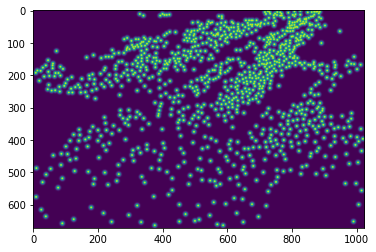

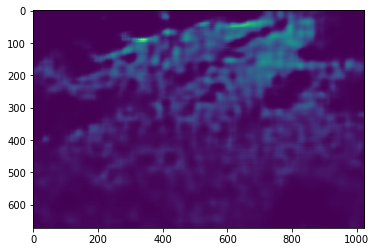

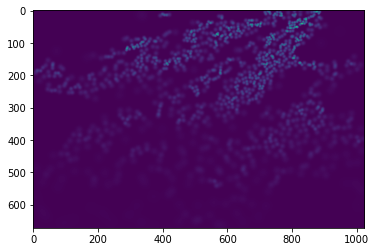

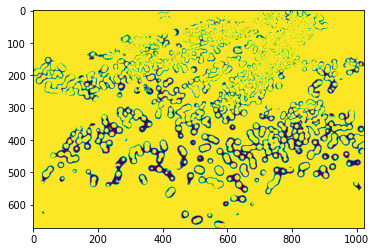

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
import matplotlib
import math

import cv2
train_loader,test_loader = loading_data()
plt.figure()
device = 'cuda'

# print(train_set[1][1].sum())
# print(train_set[1][1].max())
# plt.imshow(train_set[1][0].permute(1,2,0))
# plt.figure()
# plt.imshow(train_set[1][1].squeeze())
# def CenterLoss(pred,gt,centers,window_size=3):
#   points = torch.zeros(pred.shape[2],pred.shape[3]).to(device)
#   ct = torch.clone(torch.floor(centers).long().squeeze())
#   # ct = (ct//4*4)
#   temp = torch.clone(ct[:,0])
#   ct[:,0] = torch.clone(ct[:,1])
#   ct[:,1] = temp
#   # ct
#   # threshold = torch.ones(ct.shape[0]) * pred.shape[2]
#   mask0 = ct[:,0] >= pred.shape[2]
#   mask1 = ct[:,1] >= pred.shape[3]
#   ct[mask0,0] = pred.shape[2]-1
#   ct[mask1,1] = pred.shape[3]-1
#   # print(ct.shape)
#   # if(ct.min()<0): print(ct.min())
#   points[ct[:,0],ct[:,1]] = 1
#   # print(points[ct[1,0],ct[1,1]],points[ct[5,0],ct[5,1]],points[ct[5,0],ct[4,1]],points[223,165])
#   # print(mask)
#   # ct[:,mask]
#   # ct[[ct[:,0]>=pred.shape[2]],0] = pred.shape[2]-1
#   # ct[:,1] = torch.min(ct[:,1],pred.shape[3]-1)

#   for i in range(ct.shape[0]):
#     if ct[i,0]>=points.shape[0] or ct[i,1]>=points.shape[1]:
#       # print(ct[i,0],pred.shape[2])
#       print(ct[i],points.shape)
#       print(points.shape)
#       print("in")
#   return 0


def CenterLoss(pred,gt,centers,original_shape,fidt,distance,window_size=3):
  points = torch.zeros(original_shape[0],original_shape[1]).to('cuda')
  avg = F.avg_pool2d(gt,11,stride=1,padding=5)


  ct = torch.clone(torch.floor(centers).long().squeeze())
  # ct = (ct//4*4)
  temp = torch.clone(ct[:,0])
  ct[:,0] = torch.clone(ct[:,1])
  ct[:,1] = temp
  # ct
  # threshold = torch.ones(ct.shape[0]) * pred.shape[2]
  mask0 = ct[:,0] >= original_shape[0]
  mask1 = ct[:,1] >= original_shape[1]
  ct[mask0,0] = original_shape[0]-1
  ct[mask1,1] = original_shape[1]-1
  gaussian = torch.exp(-0.5*(distance/4)**2)
  mask1 = pred > gt + (1-torch.sqrt(gaussian))/1000
  mask2 = pred < gt - (1-torch.sqrt(gaussian))/1000
  mask3 = (gt<0.001)
  keep = torch.zeros(1,1,pred.shape[2],pred.shape[3]).to('cuda')
  keep[mask1] = 1
  keep[mask2] = 1
  keep[mask3] = 1
  return keep


batch = next(iter(test_loader))
# # batch
imgs, dens, count,centers,fidt,distance,original_shape = batch
# model = MCNN().to(device)
imgs = imgs.to('cuda')
dens = dens.to('cuda')
fidt = fidt.to('cuda')
distance = distance.to('cuda')
model2 = MCNN().to('cuda')
model2.load_state_dict(torch.load('/root/MCNN_PL1'))
# print(model(img.to('cuda')).shape)
# predicted_dens = model(imgs)
predicted_dens = model(imgs)
predicted_dens2 = model2(imgs)

print(predicted_dens.sum(),predicted_dens2.sum(),count)
keep = CenterLoss(predicted_dens,dens,centers,original_shape,fidt,distance)
distance = torch.exp(-0.5*(distance/4)**2)
print(distance.max())

plt.figure()
plt.imshow(distance.cpu().squeeze())
plt.figure()
plt.imshow(predicted_dens.squeeze().detach().cpu())
plt.figure()
plt.imshow(dens.squeeze().cpu())
plt.figure()
plt.imshow(keep.squeeze().cpu())
# print(keep)
plt.figure()

# im_keep = plt.imshow(keep.squeeze(),cmap=cmap_rb)

# plt.show()
# plt.figure()
# plt.imshow(img)
# plt.figure()
# plt.imshow(den,cmap=cmap_rb)



# # centers = centers.squeeze()
# print(centers)
# temp = torch.clone(centers[:,0])
# # print(temp)
# centers[:,0] = centers[:,1] 
# # print(centers[:,0])
# centers[:,1] = temp


# for imgs, dens, count,centers in train_loader:
#   imgs = imgs.to(device)
#   dens = dens.to(device)
#   pred = torch.zeros(1,1,imgs.shape[2],imgs.shape[3])
#   CenterLoss(pred,dens,centers)


      # print("in ")

  # points[ct] = 1
  # points = points.unsqueeze(0)
  # window = torch.ones(1,1,window_size,window_size).to('cuda')
  # # print(points.shape,window.shape)
  # keep = F.conv2d(points,window,padding='same')
  # output = keep * gt
  # output_pred = keep * pred



# dens = dens.to('cuda')
# # model = MCNN().to('cuda')
# # print(model(img.to('cuda')).shape)
# predicted_dens = model(imgs).squeeze().detach().cpu()
# plt.figure()
# plt.imshow(predicted_dens)
# plt.figure()
# plt.imshow(dens)
# # predicted_dens[predicted_dens<0.4]=0
# # predicted_dens[predicted_dens!=0] = 1
# # num, out_img = cv2.connectedComponents(predicted_dens.detach().cpu().numpy())
# # print(num)
# # predicted_dens[predicted_dens] = 0
# plt.imshow(predicted_dens.detach().cpu())
# plt.figure()
# plt.imshow(dens.cpu().squeeze())
# # print((predicted_dens>0.).sum())
# print(count_density(predicted_dens))

# print(predicted_dens)
# dens = dens.squeeze()
# print(torch.mean((predicted_dens.sum(dim=(1,2))-dens.sum(dim=(1,2)))**2))
# print(predicted_dens.sum(dim=(1,2)))
# print(dens.sum(dim=(1,2)))
# pool1 = nn.MaxPool2d(2)
# pool2 = nn.MaxPool2d(2)
# print(F.upsample(pool2(pool1(img)),scale_factor=4).shape)
# print(model(img.to('cuda')).shape)

# Train

In [9]:
import torch
import torch.nn.functional as F

def MaxpoolLoss(pred,gt):
  pred = pred.squeeze()
  keep = F.max_pool2d(pred.unsqueeze(0),3,stride=1,padding=1).squeeze()
  keep.cuda()
  # print(keep.get_device())
  keep = (pred==keep).float()*pred

  gt = gt.squeeze()
  keep_gt = F.max_pool2d(gt.unsqueeze(0),3,stride=1,padding=1).squeeze()
  keep_gt.cuda()
  # print(keep.get_device())
  keep_gt = (gt==keep_gt).float()*gt

  loss = torch.mean((keep-keep_gt)**2)

  return loss

def PatchLoss(pred,gt,patch_size=17):
  mean_pred = F.avg_pool2d(pred,patch_size,stride=1,padding=8)
  mean_gt = F.avg_pool2d(gt,patch_size,stride=1,padding=8)
  return ((mean_pred-mean_gt)**2).sum()


def CenterLoss(pred,gt,centers,original_shape,fidt,distance,window_size=3):
#   points = torch.zeros(original_shape[0],original_shape[1]).to('cuda')
#   avg = F.avg_pool2d(gt,11,stride=1,padding=5)


#   ct = torch.clone(torch.floor(centers).long().squeeze())
#   # ct = (ct//4*4)
#   temp = torch.clone(ct[:,0])
#   ct[:,0] = torch.clone(ct[:,1])
#   ct[:,1] = temp
  # ct
  # threshold = torch.ones(ct.shape[0]) * pred.shape[2]
  # mask0 = ct[:,0] >= original_shape[0]
  # mask1 = ct[:,1] >= original_shape[1]
  # ct[mask0,0] = original_shape[0]-1
  # ct[mask1,1] = original_shape[1]-1
  gaussian = torch.exp(-0.5*(distance/4)**2)
  mask1 = pred > gt + (1-torch.sqrt(gaussian))/500
  mask2 = pred < gt - (1-torch.sqrt(gaussian))/500
  mask3 = (gt<0.001)
  keep = torch.zeros(1,1,pred.shape[2],pred.shape[3]).to('cuda')
  keep[mask1] = 1
  keep[mask2] = 1
  keep[mask3] = 1

  output = keep * gt
  output_pred = keep * pred
  return ((output-output_pred)**2).sum()



def count_density(den):
  den = den.squeeze().cuda()
  # den = F.max_pool2d(den.unsqueeze(0),7).squeeze()
  keep = F.max_pool2d(den.unsqueeze(0),3,stride=1,padding=1).squeeze()
  max_large = F.max_pool2d(den.unsqueeze(0),35,stride=1,padding=17).squeeze()
  # avg_large = F.avg_pool2d(den.unsqueeze(0),135,stride=1,padding=67).squeeze()
  # avg_small = F.avg_pool2d(den.unsqueeze(0),35,stride=1,padding=17).squeeze()
  # plt.figure()
  # plt.imshow(avg.detach().cpu())
  keep = keep.cuda()
  keep = (den==keep).float()*den
  # keep
  k_max = keep.max()
  keep[(keep<0.2)|(keep<max_large*0.3)] = 0
  keep[keep>0] = 1
  weight = torch.ones(1,1,3,3).cuda()
  pred_pos = F.conv2d(keep.unsqueeze(0),weight)
  plt.figure()
  plt.imshow(pred_pos.detach().cpu().squeeze())
  est_num = (keep>0).sum().item()

  # if(est_num<200):
  #   den = F.max_pool2d(den.unsqueeze(0),7).squeeze()
  #   keep = F.max_pool2d(den.unsqueeze(0),5,stride=1,padding=2).squeeze()
  # elif est_num<500:
  #   den = F.max_pool2d(den.unsqueeze(0),5).squeeze()
  #   keep = F.max_pool2d(den.unsqueeze(0),5,stride=1,padding=2).squeeze()
  # elif est_num<1000:
  #   den  = F.max_pool2d(den.unsqueeze(0),3).squeeze()
  # else:
  #   return est_num
  
  # avg = F.avg_pool2d(den.unsqueeze(0),5,stride=1,padding=2).squeeze()
  # plt.figure()
  # plt.imshow(avg.detach().cpu())
  # keep = keep.cuda()
  # keep = (den==keep).float()*den
  # k_max = keep.max()
  # keep[keep < 0.4] = 0
  # keep[keep>0] = 1
  # weight = torch.ones(1,1,3,3).cuda()
  # pred_pos = F.conv2d(keep.unsqueeze(0),weight)
  # plt.figure()
  # plt.imshow(pred_pos.detach().cpu().squeeze())
  
  return (keep>0).sum().item()





In [12]:
import os
import torch.optim as optim
# import warnings
# warnings.filterwarnings("ignore")



torch.backends.cudnn.enabled=False
device=torch.device("cuda") if torch.cuda.is_available() else 'cpu'
# model = vgg_dl().to(device)
# model = CSRNet_DM().to(device)
# model= MCNN_OcF().to(device)
# model = CSRNet().to(device)
# model = vgg19().to(device)
# model = CSRNet_DM().to(device)
# model2.load_state_dict(torch.load('/content/drive/MyDrive/MCNN_PL1'))

L2_loss=nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=5e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.995)

train_loader,test_loader = loading_data()
# save_path = '/content/drive/MyDrive/checkpoints/MCNN4/'
# if not os.path.exists(save_path):
#   os.mkdir(save_path)

min_mae=10000000
min_epoch=0
train_loss_list=[]
epoch_list=[]
test_error_list=[]
for epoch in range(0,500):
  model.train()
  epoch_loss=0
  for i,(img,gt_dmap,gt_count,head_centers,fidt,distance,original_shape) in enumerate(train_loader): #,gt_count,head_centers
      img=img.to(device)
      gt_dmap=gt_dmap.to(device)
      fidt = fidt.to(device)
      head_centers = head_centers.to(device)
      distance = distance.to(device)
      # forward propagation
      et_dmap=model(img)
      # print(et_dmap.shape)
      # calculate loss
      # loss = torch.ones(1)
      # loss = 0
      # print(et_dmap.shape,gt_dmap.shape,fidt.shape)
      loss = L2_loss(et_dmap,gt_dmap)
      # loss = PatchLoss(et_dmap,gt_dmap) + CenterLoss(et_dmap,gt_dmap,head_centers,original_shape,fidt,distance)
      # loss = PatchLoss(et_dmap,gt_dmap) + CenterLoss(et_dmap,gt_dmap,head_centers)
      

      # loss =  MaxpoolLoss(et_dmap,gt_dmap)

      epoch_loss+=loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  #print("epoch:",epoch,"loss:",epoch_loss/len(dataloader))
  epoch_list.append(epoch)
  train_loss_list.append(epoch_loss/len(train_loader))
  # torch.save(model.state_dict(),os.path.join(save_path ,str(epoch)+".param"))

  model.eval()
  mae=0

  for i,(img,gt_dmap,gt_count,head_centers,fidt,distance,original_shape) in enumerate(test_loader):
      img=img.to(device)
      gt_dmap=gt_dmap.to(device)
      # forward propagation
      et_dmap=model(img)
      mae += abs(et_dmap.sum().item() - gt_count)
      # mae+=abs(et_dmap.data.sum()-gt_dmap.data.sum()).item()
      del img,gt_dmap,et_dmap
  if mae/len(test_loader)<min_mae:
      min_mae=mae/len(test_loader)
      min_epoch=epoch
      

  test_error_list.append(mae/len(test_loader))
  print("epoch:"+str(epoch)+" error:"+str(mae/len(test_loader))+" min_mae:"+str(min_mae)+" min_epoch:"+str(min_epoch), "loss:"+str(train_loss_list[epoch]))
  # scheduler.step()


torch.save(model.state_dict(),os.path.join('\root\vgg19' ,str(epoch)+".param"))
os.system("shutdown")



/tmp/ipykernel_581/1738156254.py:103: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((img.size[0]//self.downsample * self.downsample,img.size[1]//self.downsample * self.downsample),resample=PIL.Image.BICUBIC)
/tmp/ipykernel_581/1738156254.py:104: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  den = den.resize((den.size[0]//self.downsample* self.downsample, den.size[1]//self.downsample* self.downsample),resample=PIL.Image.BICUBIC)


epoch:0 error:tensor([432.2786]) min_mae:tensor([432.2786]) min_epoch:0 loss:1.2393238218824839e-05
epoch:1 error:tensor([348.6456]) min_mae:tensor([348.6456]) min_epoch:1 loss:1.2369794777005913e-05
epoch:2 error:tensor([443.7529]) min_mae:tensor([348.6456]) min_epoch:1 loss:1.2389195801082072e-05
epoch:3 error:tensor([337.6210]) min_mae:tensor([337.6210]) min_epoch:3 loss:1.236889100908911e-05
epoch:4 error:tensor([353.8490]) min_mae:tensor([337.6210]) min_epoch:3 loss:1.2371787522151104e-05
epoch:5 error:tensor([283.3122]) min_mae:tensor([283.3122]) min_epoch:5 loss:1.2419447275533457e-05
epoch:6 error:tensor([280.6929]) min_mae:tensor([280.6929]) min_epoch:6 loss:1.237032823894424e-05


KeyboardInterrupt: 